In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import glob
import math
import numpy as np
import pandas as pd

In [3]:
def curvature(h, ptmin, region_origin_radius,hardPtCut, first, rad=False) :
    region_origin_x = 0
    region_origin_y = 0
    x1 = h['r1']*np.cos(h['phi1']) if first else h['r2']*np.cos(h['phi2'])
    y1 = h['r1']*np.sin(h['phi1']) if first else h['r2']*np.sin(h['phi2'])
    x2 = h['r2']*np.cos(h['phi2']) if first else h['r3']*np.cos(h['phi3'])
    y2 = h['r2']*np.sin(h['phi2']) if first else h['r3']*np.sin(h['phi3'])
    x3 = h['r3']*np.cos(h['phi3']) if first else h['r4']*np.cos(h['phi4'])
    y3 = h['r3']*np.sin(h['phi3']) if first else h['r4']*np.sin(h['phi4'])
    
    distance_13_squared = (x1 - x3)*(x1 - x3) + (y1 - y3)*(y1 - y3)
    tan_12_13_half_mul_distance_13_squared = abs(y1 * (x2 - x3) + y2 * (x3 - x1) + y3 * (x1 - x2))
    # high pt : just straight
    straight = tan_12_13_half_mul_distance_13_squared * ptmin <= 1.0e-4*distance_13_squared
    def ifStraight() :
        distance_3_beamspot_squared = (x3-region_origin_x) * (x3-region_origin_x) + (y3-region_origin_y) * (y3-region_origin_y)
        dot_bs3_13 = ((x1 - x3)*( region_origin_x - x3) + (y1 - y3) * (region_origin_y-y3))
        proj_bs3_on_13_squared = dot_bs3_13*dot_bs3_13/distance_13_squared
        distance_13_beamspot_squared  = distance_3_beamspot_squared -  proj_bs3_on_13_squared
        return distance_13_beamspot_squared < (region_origin_radius+phiCut)*(region_origin_radius+phiCut)
    
    def standard() :
        # 87 cm/GeV = 1/(3.8T * 0.3)
        # 165 cm/GeV = 1/(2T * 0.3)
    
        # take less than radius given by the hardPtCut and reject everything below
        minRadius = hardPtCut*87 #  // FIXME move out and use real MagField
    
        det = (x1 - x2) * (y2 - y3) - (x2 - x3) * (y1 - y2)
    
        offset = x2 * x2 + y2*y2
    
        bc = (x1 * x1 + y1 * y1 - offset)*0.5
    
        cd = (offset - x3 * x3 - y3 * y3)*0.5
    
    
    
        idet = 1./ det;
    
        x_center = (bc * (y2 - y3) - cd * (y1 - y2)) * idet
        y_center = (cd * (x1 - x2) - bc * (x2 - x3)) * idet
    
        radius = np.sqrt((x2 - x_center)*(x2 - x_center) + (y2 - y_center)*(y2 - y_center))
        if rad: return radius
        def domore() :
            centers_distance_squared = (x_center - region_origin_x)*(x_center - region_origin_x) + (y_center - region_origin_y)*(y_center - region_origin_y)
            #minimumOfIntersectionRange = (radius - region_origin_radius_plus_tolerance)*(radius - region_origin_radius_plus_tolerance)
            #ok = centers_distance_squared >= minimumOfIntersectionRange
            return np.sqrt(centers_distance_squared)-radius # - region_origin_radius


        # return domore().where(radius > minRadius, radius <= minRadius)
        return domore()
    
    #return ifStraight().where(straight,standard())
    return standard()

In [4]:
def deltaphi(a,b,ch) :
    d = b-a
    cd = ch*d
    ca = ch*a
    return cd*(1.+0.5*ca*(ca+cd)+cd*cd*0.1667)

In [5]:
def alignRZ(h, rp, ptmin, first) :
    '''
    float radius_diff = std::abs(r1 - ro);
    float distance_13_squared = radius_diff*radius_diff + (z1 - zo)*(z1 - zo);
    
    float pMin = ptmin*std::sqrt(distance_13_squared); //this needs to be divided by radius_diff later
    
    float tan_12_13_half_mul_distance_13_squared = fabs(z1 * (getInnerR() - ro) + getInnerZ() * (ro - r1) + zo * (r1 - getInnerR())) ;
    return tan_12_13_half_mul_distance_13_squared * pMin <= thetaCut * distance_13_squared * radius_diff;
    '''
    ri = h[rp+'1'] if first else h[rp+'2']
    zi = h['z1'] if first else h['z2']
    rm = h[rp+'2'] if first else h[rp+'3']
    zm = h['z2'] if first else h['z3']
    ro = h[rp+'3'] if first else h[rp+'4']
    zo = h['z3'] if first else h['z4']
    fact = 1. if (rp=='r') else 10.
    radius_diff = fact*abs(ri - ro)
    distance_13_squared = radius_diff*radius_diff + (zi - zo)*(zi - zo)
    
    pMin = ptmin*np.sqrt(distance_13_squared) #this needs to be divided by radius_diff later
    
    tan_12_13_half_mul_distance_13_squared = fact*abs(zi * (rm - ro) + zm * (ro - ri) + zo * (ri - rm)) 
    return tan_12_13_half_mul_distance_13_squared * pMin/(distance_13_squared * radius_diff)

In [6]:
def alignRPZ(h, rp, first) :
    ri = h[rp+'1'] if first else h[rp+'2']
    zi = h['z1'] if first else h['z2']
    rm = h[rp+'2'] if first else h[rp+'3']
    zm = h['z2'] if first else h['z3']
    ro = h[rp+'3'] if first else h[rp+'4']
    zo = h['z3'] if first else h['z4']
     
    return (rm-ri)*(zo-zm) - (ro-rm)*(zm-zi)

In [7]:
def doublets(hits,l1,l2,cut=0.2) :
    nd=0
    for h1 in l1.itertuples() :
        phi = h1.phi
        hh = l2['phi'].searchsorted([phi-cut,phi+cut])
        hits.loc[h1.Index,'up0'] = hh[0]
        hits.loc[h1.Index,'up1'] = hh[1]
        nd += hh[1]-hh[0]
    return nd

In [8]:
def ml(pt1,pz1,pt2,pz2) :
    dp = pt1*pt2+pz1*pz2
    m1 = pt1*pt1+pz1*pz1
    m2 = pt2*pt2+pz2*pz2
    corr =  pt1/np.sqrt(m1)
    dp /=np.sqrt(m1*m2)
    dt = np.arccos(dp[dp<1]) 
    dtn = dt*np.sqrt(m1)*corr
    return dt,dtn

In [9]:
file = '/Users/innocent/data/pixHits.csv'
hits = pd.read_csv(file, delimiter=" ")
print '#hits', len(hits)
hits['seq'] = hits['layer'] + 4*(1-hits['isBarrel'])
hits.sort_values(by=['trackID','r'],inplace=True)
print hits.head()
print hits.tail()


#hits 427014
   trackID        pt        r         z       phi  isBarrel  layer  seq
0   100005  0.890291  5.12720 -49.32470 -2.098970         0      3    7
1   100005  0.891751  5.21688 -50.16640 -2.098250         0      3    7
2   100008  2.257280  2.74074  -9.93494  0.763363         1      1    1
3   100009  0.843968  6.83328 -49.37890  1.950680         0      3    7
4   100010  0.237142  6.59834 -26.47690 -2.260320         1      2    2
          trackID       pt         r         z      phi  isBarrel  layer  seq
427009  100000478  22.1170   6.58674   2.49151 -1.83807         1      2    2
427010  100000478  22.1158  16.15060   8.22406 -1.84053         1      4    4
427011  100000482  20.1731   2.76526   3.88990  2.75724         1      1    1
427012  100000482  20.1697   6.94866  11.98460  2.75907         1      2    2
427013  100000482  20.1698  10.71060  19.26830  2.75862         1      3    3


87191 75485 60819 48981 54155 51781 48602


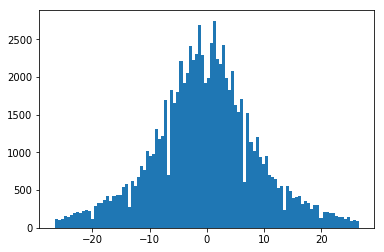

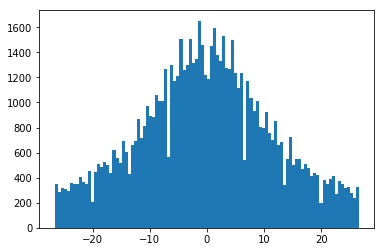

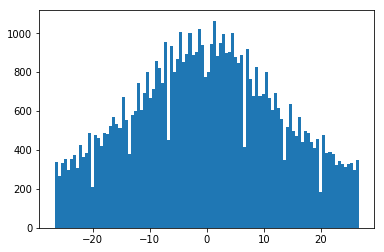

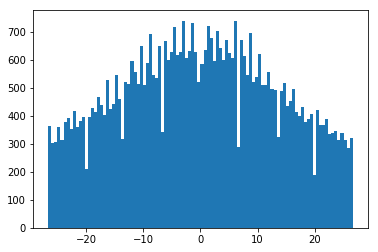

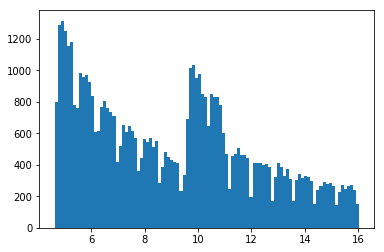

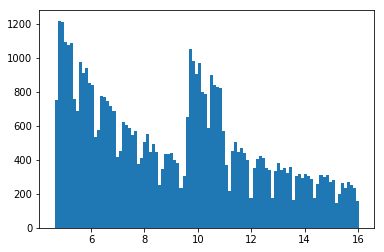

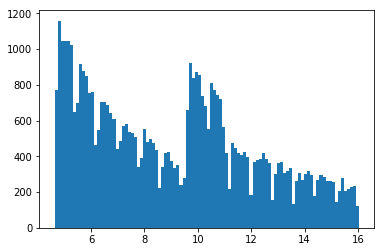

In [10]:
hb1 = hits.query('seq==1')
hb2 = hits.query('seq==2')
hb3 = hits.query('seq==3')
hb4 = hits.query('seq==4')
hf1 = hits.query('seq==5')
hf2 = hits.query('seq==6')
hf3 = hits.query('seq==7')

print len(hb1), len(hb2), len(hb3), len(hb4), len(hf1), len(hf2), len(hf3)
plt.hist(hb1['z'],log=False, bins=100)
plt.show()
plt.hist(hb2['z'],log=False, bins=100)
plt.show()
plt.hist(hb3['z'],log=False, bins=100)
plt.show()
plt.hist(hb4['z'],log=False, bins=100)
plt.show()
plt.hist(hf1['r'],log=False, bins=100)
plt.show()
plt.hist(hf2['r'],log=False, bins=100)
plt.show()
plt.hist(hf3['r'],log=False, bins=100)
plt.show()


In [11]:
print 'min/max'
print hb1.agg(['min','max'])
print hb2.agg(['min','max'])
print hb3.agg(['min','max'])
print hb4.agg(['min','max'])
print hf1.agg(['min','max'])
print hf2.agg(['min','max'])
print hf3.agg(['min','max'])

min/max
       trackID          pt        r        z      phi  isBarrel  layer  seq
min     100008    0.200008  2.73876 -26.5584 -3.14008         1      1    1
max  100000482  208.643000  3.37197  26.5703  3.14139         1      1    1
       trackID          pt        r        z      phi  isBarrel  layer  seq
min     100010    0.200002  6.57758 -26.6486 -3.14124         1      2    2
max  100000482  196.038000  7.24934  26.6184  3.14146         1      2    2
       trackID          pt        r        z      phi  isBarrel  layer  seq
min     100011    0.200015  10.7075 -26.6525 -3.14152         1      3    3
max  100000482  196.039000  11.3352  26.6503  3.14136         1      3    3
       trackID          pt        r        z      phi  isBarrel  layer  seq
min     100014    0.200014  15.8152 -26.6426 -3.14148         1      4    4
max  100000478  208.637000  16.4356  26.6525  3.14139         1      4    4
       trackID         pt        r        z      phi  isBarrel  layer  seq
min  

In [12]:
def build(hh,n) :
 return pd.DataFrame({ 'z'+n : hh['z'],
                    'r'+n : hh['r'],
                    'phi'+n : hh['phi'],
                    'pt'+n : hh['pt'],
                    'trackID' : hh['trackID']
                       })


In [13]:
def fishBone(q,t,p,c) :
 return pd.DataFrame({ 'th' : t,
                       'pz' : p,
                       'curv' : c,
                       'trackID' : q['trackID']
                       })


In [14]:
t12 = pd.merge(build(hb1,'1'),build(hb2,'2'),on='trackID')
t123 = pd.merge(t12,build(hb3,'3'),on='trackID')
t1234 = pd.merge(t123,build(hb4,'4'),on='trackID')
print len(t1234)
t1231 = pd.merge(t123,build(hf1,'4'),on='trackID')
print len(t1231)
t121 = pd.merge(t12,build(hf1,'3'),on='trackID')
t1212 = pd.merge(t121,build(hf2,'4'),on='trackID')
print len(t1212)
t11 = pd.merge(build(hb1,'1'),build(hf1,'2'),on='trackID')
t112 = pd.merge(t11,build(hf2,'3'),on='trackID')
t1123 = pd.merge(t112,build(hf3,'4'),on='trackID')
print len(t1123)

qall = pd.concat([t1234,t1231,t1212,t1123])
print len(qall)

34823
4072
13378
37771
90044


In [15]:
def plot(quad,mpt) :
  quadc = quad[quad['pt1']>mpt]

  print 'dpt'
  plt.hist(quad['pt1']-quad['pt2'],log=True, bins=100)
  plt.show()
  plt.hist(quad['pt2']-quad['pt3'],log=True, bins=100)
  plt.show()
  plt.hist(quad['pt3']-quad['pt4'],log=True, bins=100)
  plt.show()


  print 'delta123', len(quadc)
  
#dt,dtn = ml(t123['tpt'],t123['tpz'],t123['tpt2'],t123['tpz2'])
#plt.hist(dt[dt<0.1], log=True, bins=100)
#plt.show()
#plt.hist(dtn[dtn<0.1], log=True, bins=100)
#plt.show()

    
  thcut = alignRZ(quadc,'r',0.6,True)
  pzcut = alignRZ(quadc,'phi',1.0,True)
  thcut2 = alignRPZ(quadc,'r',True)
  pzcut2 = alignRPZ(quadc,'phi',True)

  curv = curvature(quadc,0.6,0.02,0.2,True)
  rad = curvature(quadc,0.6,0.02,0.2,True,True)
  field = rad/quadc['pt1']
  print 'field'
  plt.hist(field[abs(field)<500],log=True, bins=100)
  plt.show()
  print 'thcut,pzcut,curvcut',len(thcut)
  plt.hist(thcut[thcut<0.004],log=True, bins=100)
  plt.show()
  plt.hist(pzcut[pzcut<0.4],log=True, bins=100)
  plt.show()
  plt.hist(curv[abs(curv)<0.4],log=True, bins=100)
  plt.show()

  print 'thcut2,pzcut2',len(thcut2)
  plt.hist(thcut2[abs(thcut2)<0.4],log=True, bins=100)
  plt.show()
  plt.hist(pzcut2[abs(pzcut2)<0.4],log=True, bins=100)
  plt.show()




  fb123 = fishBone(quadc,thcut,pzcut,curv)
  fb = pd.merge(fb123,fb123,on='trackID')
  print 'fishbone', len(fb)  
  fb = fb[fb['curv_x']!=fb['curv_y']]
  print fb.head()
  dt = fb['th_x']-fb['th_y']
  dz = fb['pz_x']-fb['pz_y']
  dc = fb['curv_x']-fb['curv_y']
  print 'fishbone', len(fb), len(dt), len(dc)
  plt.hist(dt,log=True, bins=100)
  plt.show()
  plt.hist(dz,log=True, bins=100)
  plt.show()
  plt.hist(dc,log=True, bins=100)
  plt.show()

  plt.hist(dt[abs(dt)<0.002],log=False, bins=100)
  plt.show()
  plt.hist(dz[abs(dz)<0.01],log=False, bins=100)
  plt.show()
  plt.hist(dc[abs(dc)<0.01],log=False, bins=100)
  plt.show()
  
  print 'delta234'

  thcut = alignRZ(quadc,'r',0.6,False)
  pzcut = alignRZ(quadc,'phi',1.0,False)
  thcut2 = alignRPZ(quadc,'r',False)
  pzcut2 = alignRPZ(quadc,'phi',False)
  curv = curvature(quadc,0.6,0.02,0.2,False)
  rad = curvature(quadc,0.6,0.02,0.2,False,True)
  field = rad/quadc['pt1']
  print 'field'
  plt.hist(field[abs(field)<500],log=True, bins=100)
  plt.show()
  print 'thcut,pzcut,curvcut',len(thcut)
  plt.hist(thcut[thcut<0.004],log=True, bins=100)
  plt.show()
  plt.hist(pzcut[pzcut<0.4],log=True, bins=100)
  plt.show()
  plt.hist(curv[abs(curv)<0.4],log=True, bins=100)
  plt.show()

    
  print 'thcut2,pzcut2',len(thcut2)
  plt.hist(thcut2[abs(thcut2)<0.4],log=True, bins=100)
  plt.show()
  plt.hist(pzcut2[abs(pzcut2)<0.4],log=True, bins=100)
  plt.show()

    
  fb234 = fishBone(quadc,thcut,pzcut,curv)
  fb = pd.merge(fb234,fb234,on='trackID')
  print 'fishbone', len(fb)  
  fb = fb[fb['curv_x']!=fb['curv_y']]
  print fb.head()
  dt = fb['th_x']-fb['th_y']
  dz = fb['pz_x']-fb['pz_y']
  dc = fb['curv_x']-fb['curv_y']
  print 'fishbone', len(fb), len(dt), len(dc)
  plt.hist(dt,log=True, bins=100)
  plt.show()
  plt.hist(dz,log=True, bins=100)
  plt.show()
  plt.hist(dc,log=True, bins=100)
  plt.show()

  plt.hist(dt[abs(dt)<0.002],log=False, bins=100)
  plt.show()
  plt.hist(dz[abs(dz)<0.1],log=False, bins=100)
  plt.show()
  plt.hist(dc[abs(dc)<0.01],log=False, bins=100)
  plt.show()
 
    



In [16]:
def plotDoublets(quad,mpt) :
  quadc = quad[quad['pt1']>mpt]

  print 'dphi'
  d1 = quadc['phi2']-quadc['phi1']
  plt.hist(d1[abs(d1)<0.3], bins=100,log=True)
  plt.show()
  d2 = quadc['phi2']-quadc['phi3']
  plt.hist(d2[abs(d2)<0.3], bins=100,log=True)
  plt.show()
  d3 = quadc['phi4']-quadc['phi3']
  plt.hist(d3[abs(d3)<0.3], bins=100,log=True)
  plt.show()

  print 'dz'
  d1 = quadc['z2']-quadc['z1']
  plt.hist(d1[abs(d1)<30], bins=100,log=True)
  plt.show()
  d2 = quadc['z3']-quadc['z2']
  plt.hist(d2[abs(d2)<30], bins=100,log=True)
  plt.show()
  d3 = quadc['z4']-quadc['z3']
  plt.hist(d3[abs(d3)<30], bins=100,log=True)
  plt.show()

  print 'dr'
  d1 = quadc['r2']-quadc['r1']
  plt.hist(d1[abs(d1)<20], bins=100,log=True)
  plt.show()
  d2 = quadc['r3']-quadc['r2']
  plt.hist(d2[abs(d2)<20], bins=100,log=True)
  plt.show()
  d3 = quadc['r4']-quadc['r3']
  plt.hist(d3[abs(d3)<20], bins=100,log=True)
  plt.show()



In [17]:
#for quad in [t1234,t1231,t1212,t1123] :
#  plot(quad,0.6)

dphi


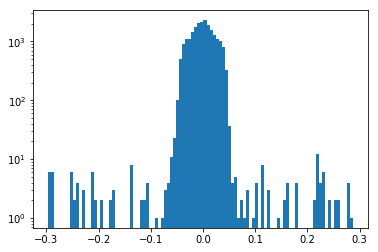

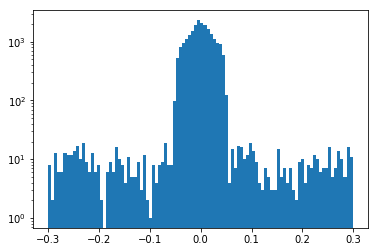

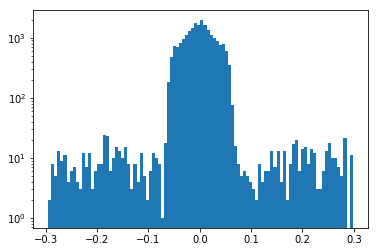

dz


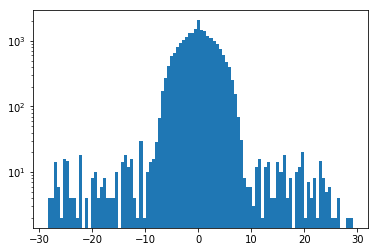

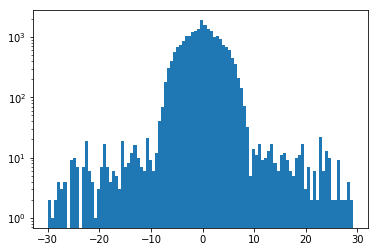

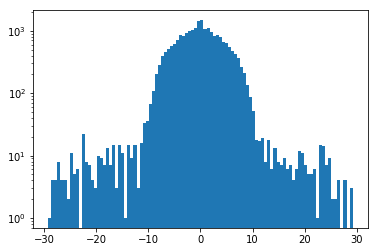

dr


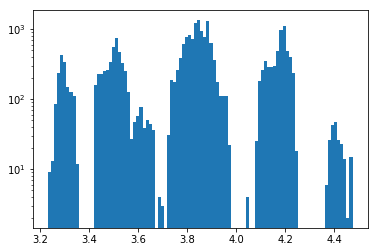

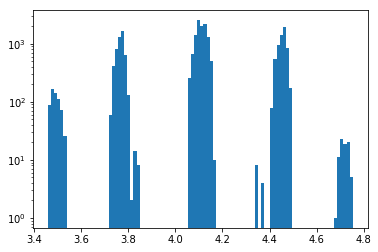

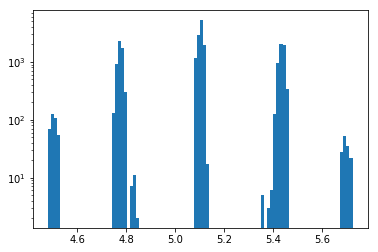

dphi


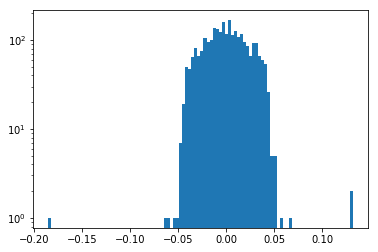

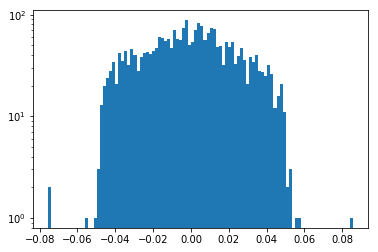

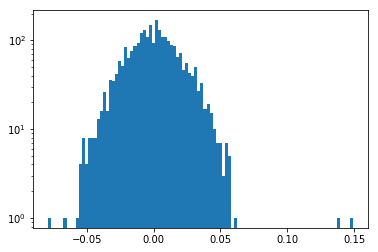

dz


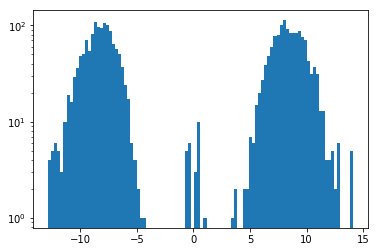

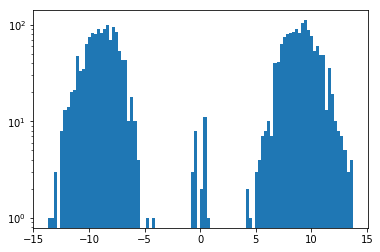

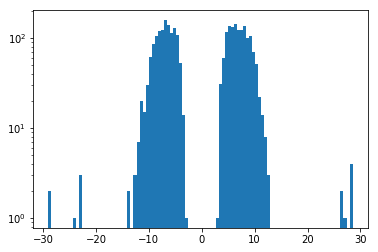

dr


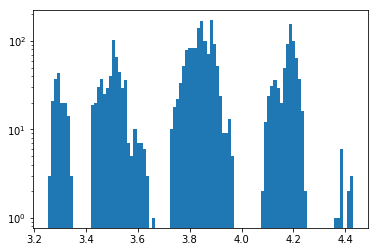

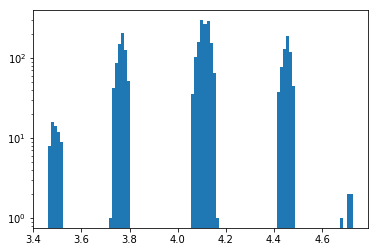

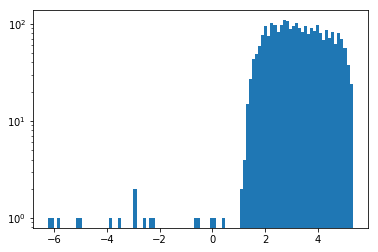

dphi


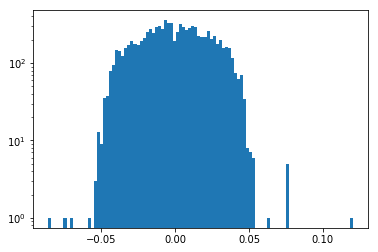

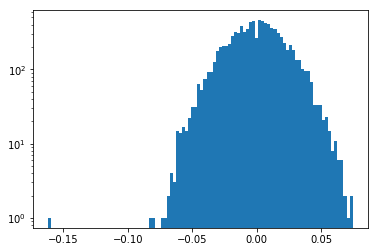

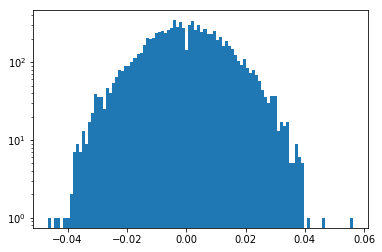

dz


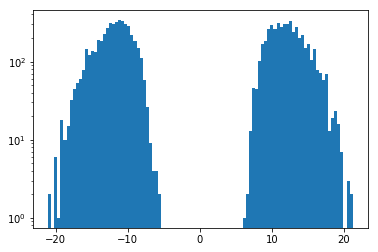

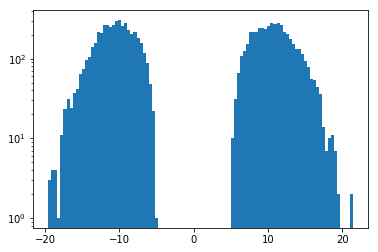

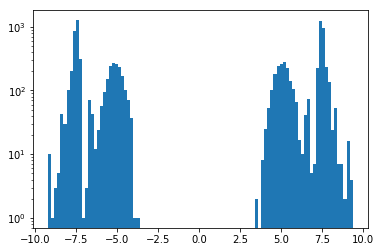

dr


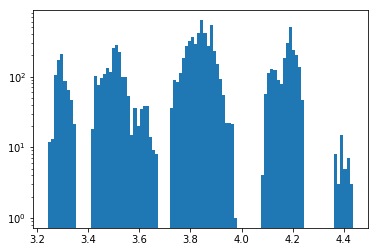

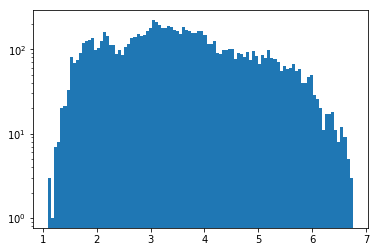

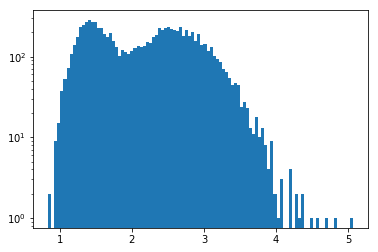

dphi


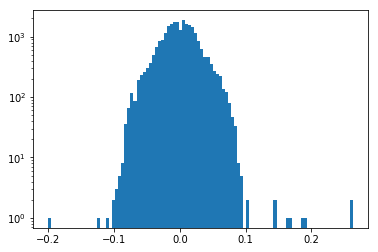

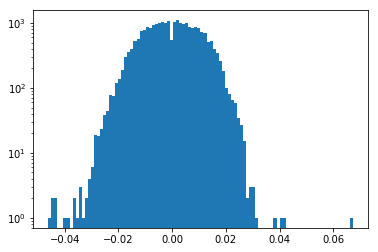

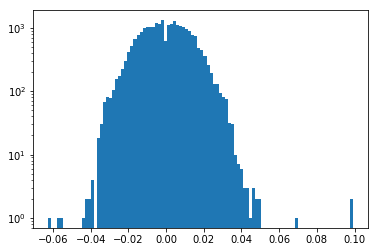

dz


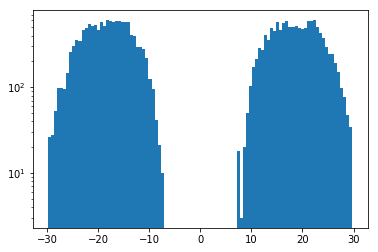

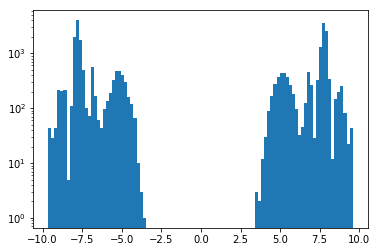

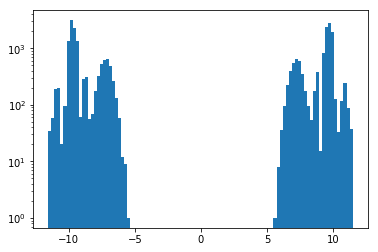

dr


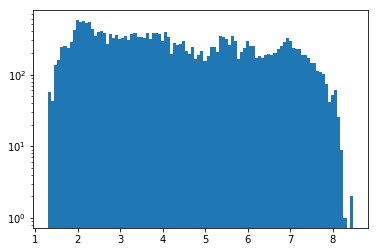

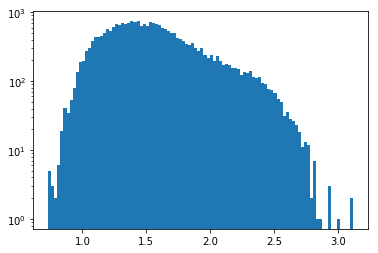

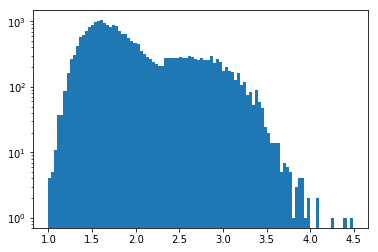

In [22]:
for quad in [t1234,t1231,t1212,t1123] :
  plotDoublets(quad,0.5)